In [7]:
#Notebook's settings
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/jax-strong-lensing/'
sys.path.append(Folder)

# Basic imports
import matplotlib.pyplot as plt
import matplotlib as mpl
# If you use PyCharm notebooks with dark theme
plt.style.use('default')


import numpy as np
import math
from functools import partial

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

# To read fits
from astropy.io import fits


from herculens.Instrument.psf import PSF
#Fontsize
FS=18

# Read data

In [8]:
with fits.open('./data/Aymerics_data/data.fits') as hdul:
    data=hdul[0].data.astype('float64')

with fits.open('./data/Aymerics_data/psf.fits') as hdul:
    psf=hdul[0].data.astype('float64')

In [9]:
import json
with open('./data/Aymerics_data/noise_properties.json') as f:
    noise_properties=json.load(f)

In [10]:
exposure_time=2000
bkg_noise_sigma=noise_properties['sigma_bg']

pixel_number=data.shape[0] #The image is 100x100 pixels
kwargs_numerics={'supersampling_factor': 1, 'convolution_type': 'grid'}
pixel_scale=0.08 #The resolution is 0.08 arcsec/pixel
annulus_mask_borders=[0.5, 3] # border radii of region covering Einstein ring

PSF_class=PSF(psf_type='PIXEL',kernel_point_source=psf)

In [11]:
def extent(shape,pixel_scale):
    return np.tile(np.array([-shape[0]/2,shape[1]/2]),2)*pixel_scale

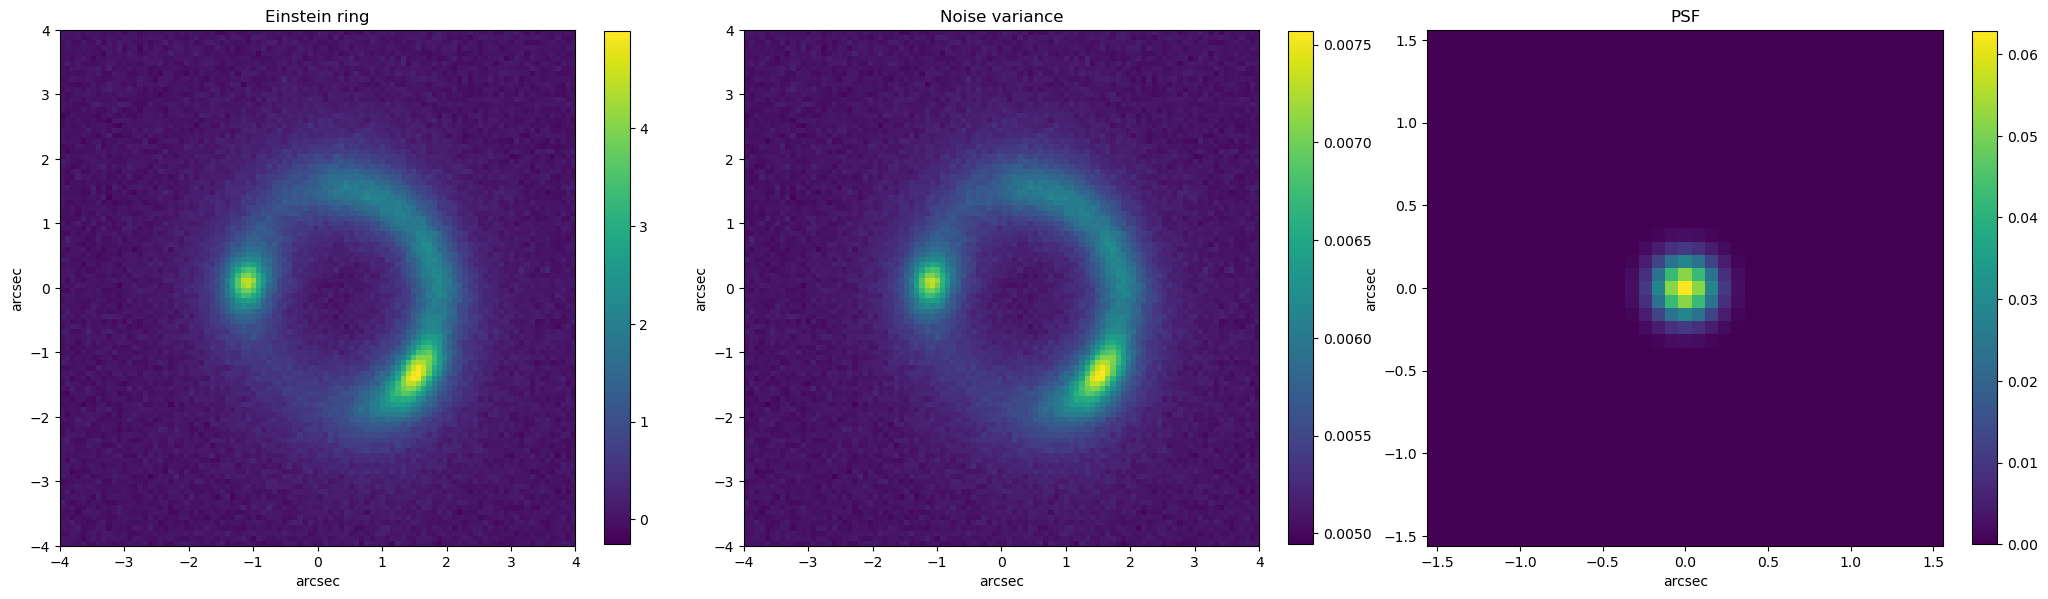

In [12]:
fig,ax=plt.subplots(1,3,figsize=(25,7))
img_arr=[]

img_arr+=[ax[0].imshow(data,extent=extent(data.shape,pixel_scale))]
img_arr+=[ax[1].imshow(data/exposure_time+noise_properties['sigma_bg']**2,extent=extent(data.shape,pixel_scale))]
img_arr+=[ax[2].imshow(psf,extent=extent(psf.shape,pixel_scale))]

ax[0].set_title('Einstein ring')
ax[1].set_title('Noise variance')
ax[2].set_title('PSF')

for i in range(3):
    fig.colorbar(img_arr[i],ax=ax[i],fraction=0.045)
    ax[i].set_ylabel('arcsec')
    ax[i].set_xlabel('arcsec')

plt.show()

# inference

In [13]:
from herculens.Coordinates.pixel_grid import PixelGrid
# Set up PixelGrid
ra_at_xy_0 = dec_at_xy_0 = (1-pixel_number)*pixel_scale / 2
kwargs_pixel = {'nx': pixel_number, 'ny': pixel_number,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': pixel_scale * np.eye(2)}
pixel_grid=PixelGrid(**kwargs_pixel)

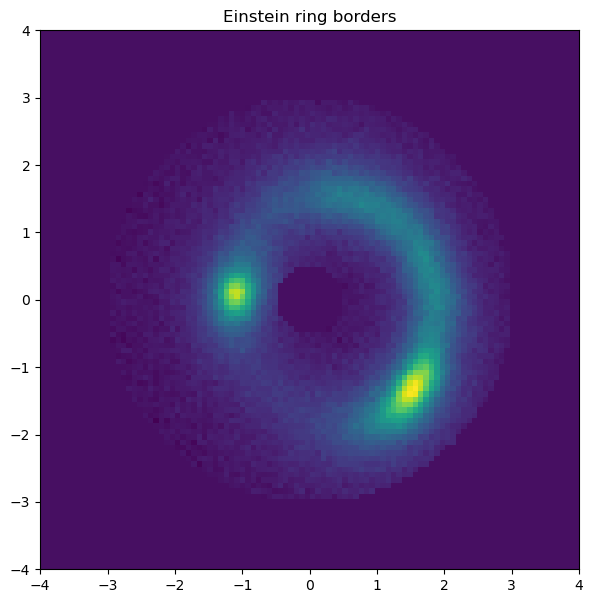

In [15]:
annulus_mask_borders=[0.5, 3] # border radii of region covering Einstein ring
radius = np.hypot(*pixel_grid.pixel_coordinates)
rmin, rmax = annulus_mask_borders
annulus_mask = ((radius >= rmin) & (radius <= rmax))
"""
mask_borders=np.zeros_like(data)
mask_borders[np.abs(radius-rmax)<0.3]=True
mask_borders[np.abs(radius-rmin)<0.3]=True
"""

fig=plt.figure(figsize=(25,7))
img=plt.imshow(data*annulus_mask,extent=extent(data.shape,pixel_scale))
plt.title('Einstein ring borders')
plt.show()

In [16]:
# Import class that handles simulation of gravitational lenses and some default parameters of the source and lens
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class,default_unperturbed_model_kwargs

pixel_number=data.shape[0] #The image is 100x100 pixels
supersampling_factor=1 #The lens plane and the source plane grids have the same discretization
pixel_scale=0.08 #The resolution is 0.08 arcsec/pixel
#PSF_class=PSF(**{'psf_type': 'GAUSSIAN', 'fwhm': PSF_FWHM})
PSF_class=PSF(psf_type='PIXEL',kernel_point_source=psf)
Observed_image=np.array(data)

source_light_model_list = ['SERSIC_ELLIPSE'] #Source's surface brightness
lens_mass_model_list = ['SIE', 'SHEAR']  #Lens' gravitational potential SIE+Shear+Inhomogeneities
lens_light_model_list = [] # No lens light


# Define the class using default parameters for the picked model
Surface_brightness=Surface_brightness_class(pixel_number,pixel_scale,PSF_class,bkg_noise_sigma,exposure_time,kwargs_numerics,
                                            source_light_model_list,default_unperturbed_model_kwargs['kwargs_source'],
                                            lens_mass_model_list,default_unperturbed_model_kwargs['kwargs_lens'],
                                            lens_light_model_list,default_unperturbed_model_kwargs['kwargs_lens_light'],
                                            annulus_mask_borders)

## Extracting surface brightness anomalies $\delta I$

We base our inference method on power spectrum $P_{\delta I}$ of the Einstein ring anomalies $\delta I$.
To extract perturbations $\delta I$ we fit image $I$ with a model Sersic source + SIE lens + External shear that is smooth and doesn't have power to absorb much perturbations.
The residuals of such a fit are an approximation of the actual anomalies $\delta I$ induced by potential inhomogeneities $\delta \psi$

In [17]:
# Import function that fits image of gravitational lens with the model encoded in Surface_brightness class
from GRF_perturbations.Modules.Utils import scipy_fit_Surface_Brightness,kwargs_values_to_float

kwargs_unperturbed_model=scipy_fit_Surface_Brightness(Observed_image,Surface_brightness,method='BFGS') #this is just chi^2 minimization with scipy.optimize.minimize backbone
kwargs_values_to_float(kwargs_unperturbed_model) # jaxified function returns values as DeviceArray, but we want simple floats

/Users/egordanilov/miniforge3/envs/env_GRF/lib/python3.9/site-packages/scipy/optimize/_minimize.py:547: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


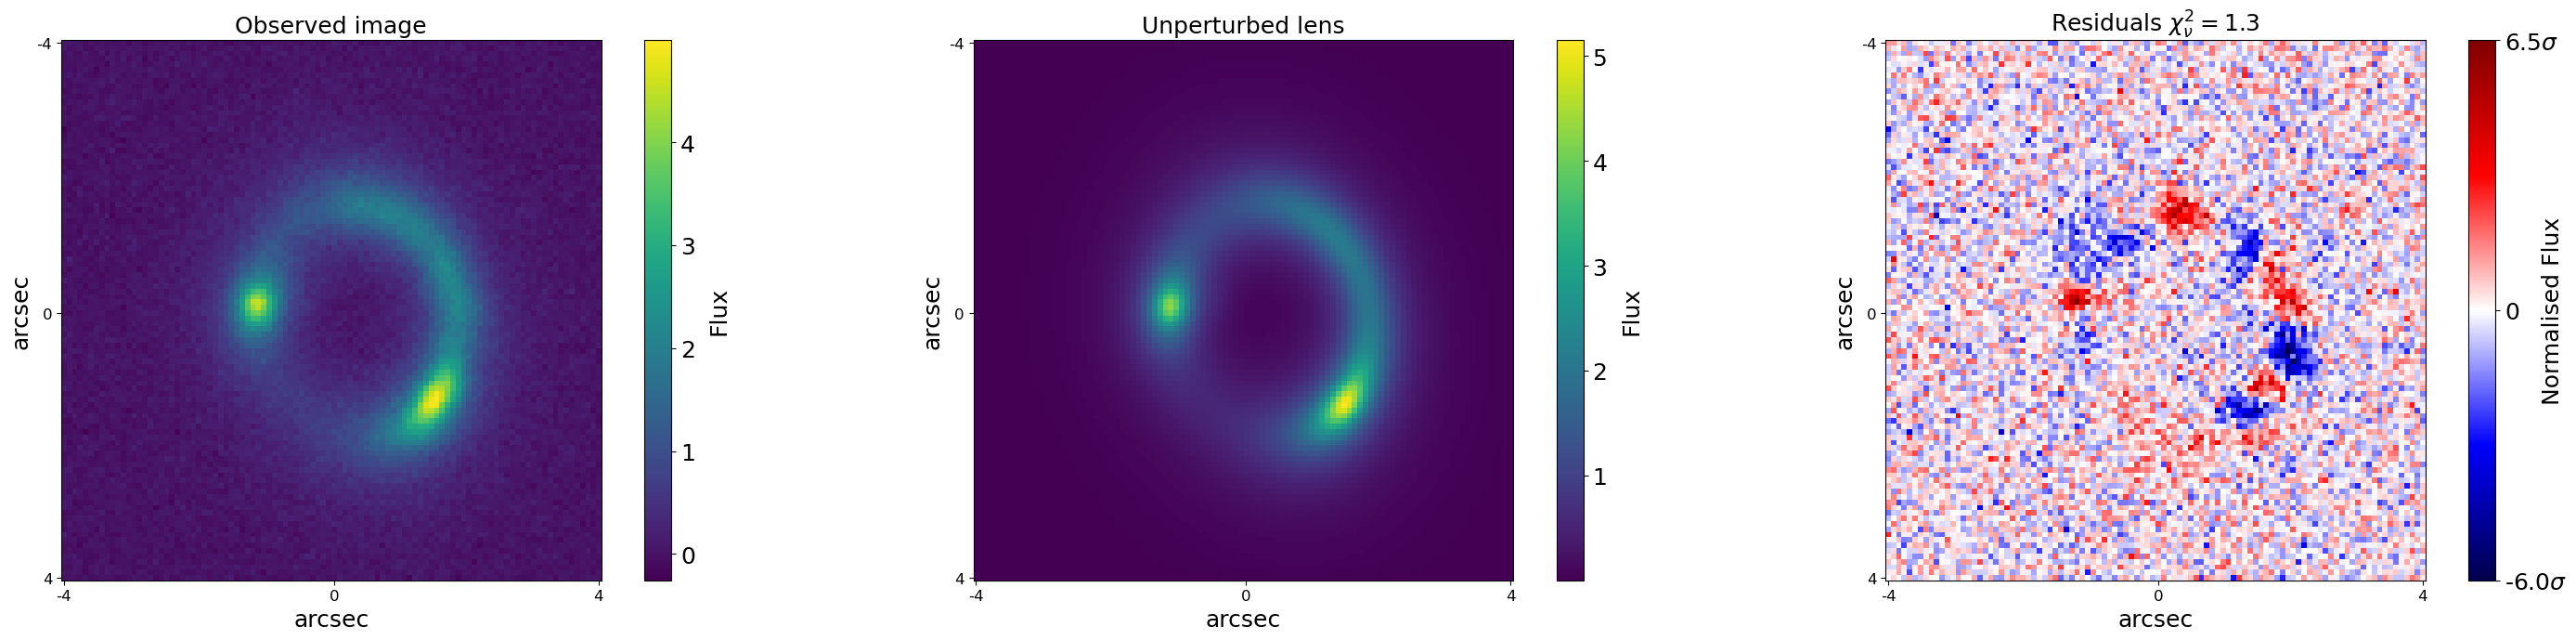

In [18]:
#Initialize image generation function
simulate_unperturbed_image = Surface_brightness.unperturbed_image_getter
simulate_unperturbed_image_pure = lambda model_kwargs: simulate_unperturbed_image(model_kwargs, Noise_flag=False)
# args<->kwargs transformation
SL_parameters=Surface_brightness.parameters()
# args to start fitting from
initial_guess=SL_parameters.initial_values()

# get function that simulates unperturbed gravitational lens
simulate_unperturbed_image=Surface_brightness.unperturbed_image_getter


Unperturbed_image=simulate_unperturbed_image(kwargs_unperturbed_model,Noise_flag=False) # Image of Einstein ring with no perturbations and noise
Observed_anomalies=Observed_image-Unperturbed_image # Fit residuals that should approximate perturbations and noise


fig,ax=plt.subplots(1,3,figsize=(30,7))

Normalised_residuals=Observed_anomalies/np.sqrt(Surface_brightness.noise_var)
images=[Observed_image,Unperturbed_image,Normalised_residuals]
titles=['Observed image','Unperturbed lens','Residuals '+r'$\chi^2_{\nu}=$'+'{:.1f}'.format((Normalised_residuals**2).sum()/(Normalised_residuals.size-1))]

# Observed and fitted images
for i in range(2):
    img_figure=ax[i].imshow(images[i])
    cbar=fig.colorbar(img_figure,ax=ax[i],fraction=0.045)
    cbar.ax.tick_params(labelsize=FS)
    cbar.ax.set_ylabel('Flux',rotation=90,fontsize=FS,labelpad=10)

# Normalised residuals (i.e. perturbations normalised by noise map)
img_figure=ax[2].imshow(Normalised_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))
colorborders=[math.ceil(Normalised_residuals.min()*1e+1)/1e+1,0,math.floor(Normalised_residuals.max()*1e+1)/1e+1]
ticksborders=[math.ceil(Normalised_residuals.min()*1e+2)/1e+2,0,math.floor(Normalised_residuals.max()*1e+2)/1e+2]
cbar=fig.colorbar(img_figure,ax=ax[2],ticks=ticksborders,fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=FS,labelpad=-20)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'],fontsize=FS)


for i,title in enumerate(titles):
    ax[i].set_title(title,fontsize=FS)
    ax[i].set_xticks([0,50,100-1])
    ax[i].set_xticklabels([-4,0,4],fontsize=12)
    ax[i].set_yticks([0,50,100-1])
    ax[i].set_yticklabels([-4,0,4],fontsize=12)
    ax[i].set_xlabel('arcsec',fontsize=FS)
    ax[i].set_ylabel('arcsec',fontsize=FS)

plt.tight_layout()
plt.show()

So we see that unperturbed model indeed can not fully describe the observed image, so we significantly detect the anomalies $\delta I$.
We can quantify those anomalies in terms of their radial power spectrum $P_{\delta I}(|k|)$

# Gradient descent-based optimization of potential inhomogeneities

So in these section we will optimize power spectrum of gravitational potential inhomogeneities $P_{\delta \psi}$ using gradient descent optimization.
Though we are not interested in random seed $\phi$, so we will sample inhomogeneities for many $\phi$ and construct likelihood to account for $\phi$-defined variation as for the noise
Given the parameters of the unperturbed model we can define all the classes that we will need for further this process.

## Radial power spectrum of the observed anomalies

In [19]:
from GRF_perturbations.Modules.GRF_inhomogeneities_class import GRF_inhomogeneities_class # Class that handles generation of GRF
from GRF_perturbations.Modules.Inference_class import Inference_class # Class that handles all the inference related procedures

#How many random seeds phi to use in the inference
Phase_seeds_number=400  # it should be big enough to ensure statistical significance of mean and variance of the anomalies power spectrum
GRF_class=GRF_inhomogeneities_class(pixel_number, pixel_scale, Phase_seeds_number)

# Renew the model of unperturbed lens to the fitted one
# Define the class using default parameters for the picked model
Surface_brightness=Surface_brightness_class(pixel_number,pixel_scale,PSF_class,bkg_noise_sigma,exposure_time,kwargs_numerics,
                                            source_light_model_list,kwargs_unperturbed_model['kwargs_source'],
                                            lens_mass_model_list,kwargs_unperturbed_model['kwargs_lens'],
                                            lens_light_model_list,kwargs_unperturbed_model['kwargs_lens_light'],
                                            annulus_mask_borders)

# In order to account for absorption of anomalies on the stage of lens fitting that class can also fit lens
# In Gradient descent-based optimization we will not use this fitting due to high computation load
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=0)

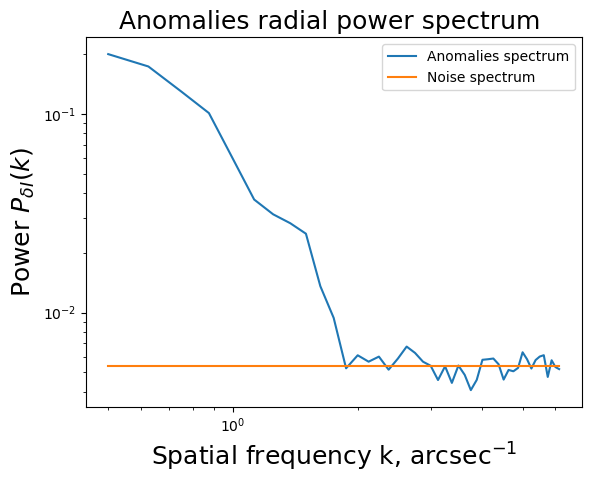

In [20]:
Data_spectrum=Inference.compute_radial_spectrum(Observed_anomalies) # This function computes radial power spectrum of anomalies withing Einstein ring region
Estimated_Noise_spectral_density=(Surface_brightness.noise_var*Surface_brightness.annulus_mask).sum()/Surface_brightness.annulus_mask.sum()
plt.loglog(Surface_brightness.frequencies,Data_spectrum,label='Anomalies spectrum')
plt.loglog(Surface_brightness.frequencies,np.ones_like(Data_spectrum)*Estimated_Noise_spectral_density,label='Noise spectrum')
plt.xlabel('Spatial frequency k, arcsec'+r'$^{-1}$',fontsize=FS)
plt.ylabel('Power '+r'$P_{\delta I}(k)$',fontsize=FS)
plt.title('Anomalies radial power spectrum ',fontsize=FS)
plt.legend()
plt.show()

In [21]:
print('Spectral SNR={:.3f}'.format(10*np.log10(np.mean(Data_spectrum-Estimated_Noise_spectral_density,axis=-1)/Estimated_Noise_spectral_density)))

Spectral SNR=4.793


Well, with this kind of SNR the method should work. I am a bit worried about the fact that these are large scale anomalies, so the fitting could have absorbed a lot.

In [22]:
# the first argument stands for the set of Power spectra
def Spectra_Loss_Chi_sq(Model_spectra,Data_spectrum,Phase_seeds_number):

    data_log_spectrum=jnp.log(Data_spectrum)
    models_log_spectra=jnp.log(Model_spectra)

    Mean_logN=models_log_spectra.mean(axis=-2) #Mu_A.Beta
    Sigma_logN=jnp.sqrt(jnp.power(models_log_spectra-Mean_logN,2).sum(axis=-2)/(Phase_seeds_number-1)) #Sigma_A,Beta

    #Chi^2 loss for Normal likelihood of log-Power spectrum log(P[A,Beta])
    return jnp.mean(jnp.power((data_log_spectrum - Mean_logN)/Sigma_logN, 2), axis=-1)

Spectra_Loss_function=lambda Model_spectra: Spectra_Loss_Chi_sq(Model_spectra,Data_spectrum,Phase_seeds_number) # Pure Loss as a function of anomalies power spectra

So now we have all set of functions needed for gradient descent $\chi^2(A,\beta)$, $\vec{\nabla} \ \chi^2(A,\beta)$, $\vec{\nabla} \vec{\nabla} \ \chi^2(A,\beta)$
Let's test how long it takes to evaluate the values

Sequential Loss

In [23]:
GRF_Loss=jax.jit(lambda GRF_params: Inference.GRF_Power_Spectrum_Loss(GRF_params,Phase_seeds_number,Spectra_Loss_function,fit_image=False)) # Pure Loss as a function of logA and Beta
GRF_grad_Loss=jax.jit(jax.grad(GRF_Loss)) # Gradient of Loss function
GRF_hessian_Loss=jax.jit(jax.jacfwd(jax.jacrev(GRF_Loss))) # Hessian of Loss function

In [24]:
import time
start_time=time.time()

print('Loss={:.2f}'.format(GRF_Loss([-7.6,2.]).block_until_ready()),'evaluation time={:.2f} sec'.format(time.time()-start_time))
start_time=time.time()
print('Gradient of Loss= ',np.array(GRF_grad_Loss([-7.6,2.])).round(2),'evaluation time={:.2f} sec'.format(time.time()-start_time))
start_time=time.time()
print('Hessian of Loss= ',np.array(GRF_hessian_Loss([-7.6,2.])).flatten().round(2),'evaluation time={:.2f} sec'.format(time.time()-start_time))

Loss=1.57 evaluation time=17.61 sec
Gradient of Loss=  [ 2.31 -0.8 ] evaluation time=11.65 sec
Hessian of Loss=  [16.04 -4.04 -4.04  1.31] evaluation time=24.62 sec


Parallel Loss

In [27]:
GRF_parallel_Loss=lambda GRF_params: Inference.GRF_Power_Spectrum_Loss_pmap(GRF_params,Phase_seeds_number,Spectra_Loss_function,num_cores=max_thread_numbers,fit_image=False) # Pure Loss as a function of logA and Beta

"""
GRF_parallel_grad_Loss=jax.grad(GRF_parallel_Loss) # Gradient of Loss function
GRF_parallel_hessian_Loss=jax.jacfwd(jax.jacrev(GRF_parallel_Loss)) # Hessian of Loss function
"""

'\nGRF_parallel_grad_Loss=jax.grad(GRF_parallel_Loss) # Gradient of Loss function\nGRF_parallel_hessian_Loss=jax.jacfwd(jax.jacrev(GRF_parallel_Loss)) # Hessian of Loss function\n'

In [28]:
import time
start_time=time.time()

print('Parallel Loss={:.2f}'.format(GRF_parallel_Loss([-7.6,2.]).block_until_ready()),'evaluation time={:.2f} sec'.format(time.time()-start_time))

/Users/egordanilov/miniforge3/envs/env_GRF/lib/python3.9/site-packages/jax/_src/dispatch.py:232: UserWarning: The jitted function GRF_Power_Spectrum_Loss_pmap includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Parallel Loss=1.57 evaluation time=17.40 sec


In [29]:
GRF_parallel_Loss([-7.6,2.])

DeviceArray(1.56546965, dtype=float64)

In [30]:
GRF_Loss([-7.6,2.])

DeviceArray(1.56546965, dtype=float64)

The evaluation of the functions is quite fast.
Now let us define the bounds of the region in which we want to use our algorithm

## Bounds on $log(A)$ and $\beta$

### Bounds on $\beta$

Minimal $\beta$ would correspond to flat field GRF $\delta \psi$, so $\beta_{min}=0$

Since $\beta$ defines scale of perturbations $\lambda$ we constrain it from above based on condition $\lambda<\theta_{E}$, where $\theta_{E}$ is the Einstein radius of the unperturbed lens.
Estimation of $\lambda$ can be found from Lagrange's Mean Value Theorem for the potential perturbations Power spectrum:
$\int PS(k) dk_x dk_y = PS(\widetilde{k}) \int dk_x dk_y $

$\widetilde{\lambda}=\frac{1}{\widetilde{k}}=\left(\frac{\sum_{k_x} \sum_{k_y} k^{-\beta}}{N^2}\right)^{\frac{1}{\beta}}$


In [31]:
betas=np.linspace(0.1,6,90)

def get_true_scale(beta):
    total_energy=GRF_class.field_variance([0.,beta],field='potential')
    scale=jnp.power(total_energy/(GRF_class.pixel_number**2),1/beta)
    return scale

scales=np.vectorize(get_true_scale)(betas)
theta_E=Surface_brightness.kwargs_unperturbed_model['kwargs_lens'][0]['theta_E']
minimal_Beta=0
maximal_Beta=betas[np.argmin(np.abs(scales-theta_E))]
print('Minimal Beta={:.1f}'.format(minimal_Beta))
print('Maximal Beta={:.1f}'.format(maximal_Beta))

Minimal Beta=0.0
Maximal Beta=4.7


## Bounds on $log(A)$

Potential inhomogeneities $\delta \psi$ should be perturbations of the main lens gravitational potential $\psi$, however they should still alter the result Einstein ring.
We put bounds on amplitude of potential inhomogeneities $\delta \psi$ in terms of corresponding differential deflection $\delta \alpha$.
For $\delta \psi$ effect to be notable the minimal deflection should be greater than the pixel scale: $\delta \alpha (A_{min},\beta_{min})=pixel\_scale$
For $\delta \psi$ to be a perturbation of $\psi$ the perturbation deflection should be much less than Einstein radius: $\delta \alpha (A_{max},\beta_{max})=0.2 \times \theta_E$

The extraction of log(A) is quite easy for $\delta \alpha (A,\beta)=\sqrt{A} \times \delta \alpha (0,\beta)$


In [32]:
#dalpha(0,beta)
def maximal_deflection_for_unitA(beta):
    alphas=np.zeros((2,Phase_seeds_number,pixel_number,pixel_number))
    alphas[0]=[GRF_class.alpha([0.,beta],GRF_class.tensor_unit_Fourier_images[i],direction='y') for i in range(Phase_seeds_number)] #d(psi)/dy
    alphas[1]=[GRF_class.alpha([0.,beta],GRF_class.tensor_unit_Fourier_images[i],direction='x') for i in range(Phase_seeds_number)] #d(psi)/dx
    absolute_alpha=np.sqrt(alphas[0]**2+alphas[1]**2) # |nabla psi|
    return absolute_alpha.max(axis=(1,2)).mean() # maximal deflection averaged over GRF random seeds

minimal_logA=np.log10((pixel_scale/maximal_deflection_for_unitA(0.))**2)
maximal_logA=np.log10((0.2*theta_E/maximal_deflection_for_unitA(4.7))**2)
print('Minimal log(A)={:.2f}'.format(minimal_logA))
print('Maximal log(A)={:.2f}'.format(maximal_logA))

Minimal log(A)=-10.35
Maximal log(A)=-7.03


## Gradient descent optimization of $log(A)$ and $\beta$

Now we just need to minimize our Loss function within the selected bounds.
In scipy.optimize.minimize only one 'trust-constrained' method can simultaneously use hessian and support bounds

In [33]:
import scipy
step = 1 # fitting Step number
history=np.zeros((0,2)) # history of arguments
loss_history=np.zeros(0) # history of losses
bounds=((minimal_logA, maximal_logA), (minimal_Beta, maximal_Beta)) # Bounds from the previous section
initial_args=[minimal_logA,(maximal_Beta+minimal_Beta)/2] # Start from almost no inhomogeneities with somewhat average spatial scale

def callbackF_trust_constr(Xi,optimizer):
    global step
    global history
    global loss_history

    if step==1:
        print(' step      logA        Beta        Loss       dL/dlogA      dL/dBeta')

    loss=GRF_Loss(Xi)
    grad=GRF_grad_Loss(Xi)
    print('{0:4d}      {1:3.3f}      {2: 3.3f}      {3: 3.3f}      {4: 3.3f}      {5: 3.3f}'.format(step, Xi[0], Xi[1], loss,grad[0],grad[1]))

    step += 1
    loss_history=np.append(loss_history,optimizer.fun)
    history=np.append(history,[Xi],axis=0)

res=scipy.optimize.minimize(GRF_Loss,initial_args,method='trust-constr',jac=GRF_grad_Loss,hess=GRF_hessian_Loss,
                            bounds=bounds,options={'disp': True},callback=callbackF_trust_constr,tol=0.001)

 step      logA        Beta        Loss       dL/dlogA      dL/dBeta
   1      -10.355       2.337       20.986      -1.355       0.232
   2      -9.609       2.221       17.915      -8.159       1.996
   3      -7.039       1.263       12.635       33.224      -14.419
   4      -7.041       4.657       5.198       10.140       2.650
   5      -7.080       4.632       4.840       9.821       2.644
   6      -7.344       4.562       2.576       5.967       1.879
   7      -7.930       4.334       0.848      -0.752      -0.446
   8      -7.874       4.338       0.829      -0.126      -0.165
   9      -7.874       4.338       0.829      -0.126      -0.165
  10      -7.863       4.340       0.803      -0.003      -0.099
  11      -7.863       4.340       0.803      -0.003      -0.099
  12      -7.863       4.340       0.803      -0.003      -0.099
  13      -7.863       4.340       0.803      -0.003      -0.099
  14      -7.863       4.340       0.803      -0.003      -0.099
  15      -7.8

## Best fit results

First let's take a look at the model of spectrum that we have obtained and compare it to the data that we observed

In [20]:
from GRF_perturbations.Modules.Utils import jax_map # jaxified function map(f,arr)
getter_SB_Anomalies_spectra=jax.jit(lambda unit_Fourier_image: Inference.Anomalies_Radial_Power_Spectrum(res.x,unit_Fourier_image, Noise_flag=True,fit_image=False)) # get P_dI for A,beta,phi
SB_Anomalies_spectra=jax_map(getter_SB_Anomalies_spectra,GRF_class.tensor_unit_Fourier_images) # map the getter over random seeds phi

Mean_logN=np.log(SB_Anomalies_spectra).mean(axis=-2) # Mean log(Spectrum) in the best fit log(A) and Beta
Sigma_logN=jnp.sqrt(jnp.power(np.log(SB_Anomalies_spectra)-Mean_logN,2).sum(axis=-2)/(len(SB_Anomalies_spectra)-1)) # Uncertainty of log(Spectrum) in the best fit log(A) and Beta

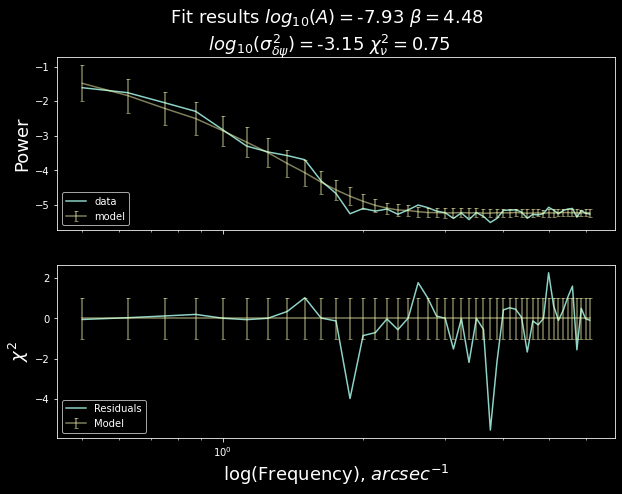

In [28]:
fig,ax=plt.subplots(2,1,figsize=(10,7),sharex=True)

Data_log_spectrum=np.log(Data_spectrum)
ax[0].plot(Surface_brightness.frequencies,Data_log_spectrum,label='data')
ax[0].errorbar(Surface_brightness.frequencies,Mean_logN,Sigma_logN,capsize=2,alpha=0.5,label='model')
ax[0].set_ylabel('Power',fontsize=FS)

Chi_sq=jnp.power((Data_log_spectrum-Mean_logN)/Sigma_logN,2)*np.sign(Data_log_spectrum-Mean_logN)
ax[1].plot(Surface_brightness.frequencies,Chi_sq,label='Residuals')
ax[1].errorbar(Surface_brightness.frequencies,np.zeros_like(Chi_sq),np.ones_like(Chi_sq),capsize=2,alpha=0.5,label='Model')
ax[1].set_xlabel('log(Frequency), '+r'$arcsec^{-1}$',fontsize=FS)
ax[1].set_ylabel(r'$\chi^2$',fontsize=FS)
ax[1].set_xticks([-4,-2,0,2])
ax[1].set_xticklabels([str(x)+r'$\sigma$' for x in[-4,-2,0,2]])


for i in range(2):
    ax[0].set_xscale('log')
    ax[i].legend(loc='lower left')

fig.suptitle('Fit results '+r'$log_{10}(A)=$'+'{:.2f} '.format(res.x[0])+
             r'$\beta=$'+'{:.2f} \n'.format(res.x[1])+
             r'$\ log_{10}(\sigma^2_{\delta \psi})=$'+'{:.2f} '.format(
            np.log10(GRF_class.field_variance(res.x,field='potential')))+
            r'$\chi^2_{\nu}=$'+'{:.2f}'.format(jnp.power((Data_log_spectrum-Mean_logN)/Sigma_logN,2).mean()),fontsize=FS)
plt.show()

Weeelll, the constraint on Beta is 4.7. So if the fit values is close to it Fisher analysis is pretty much pointless, because likelihood is not Gaussian at all (look up the paper Fig.4 row 3)

Nevertheless the fit of spectrum is relatively good, so I am quite optimistic about fitted logA and Beta, but the constraints from Fisher analysis are going to be very questionable


The fit is relatively good, but the fact that residuals reach the value of $4\sigma$ point that it is not perfect
Let's now take a look at confidence ellipsis. We can get one by approximating covariance matrix with Fisher matrix.
In a turn, Fisher matrix can be evaluated from chi^2 (Loss) hessian (https://arxiv.org/pdf/0906.4123.pdf)

$F=\frac{1}{2} \begin{bmatrix} \frac{\partial^2}{\partial x^2} & \frac{\partial^2}{\partial x \partial y} \\ \frac{\partial^2}{\partial x \partial y} & \frac{\partial^2}{\partial y^2} \\ \end{bmatrix} \chi^2$ ,


$\Sigma=\begin{bmatrix} \sigma_x^2 & \sigma_{xy} \\ \sigma_{xy} & \sigma_y^2 \\ \end{bmatrix} \approx F^{-1}$

In [29]:
fisher_matrix = 1/2*GRF_hessian_Loss(res.x)
covariance_matrix= jnp.linalg.inv(fisher_matrix)

import corner
# Sample a lot of points from the covariance matrix
def draw_from_gaussian(mu, S, ndraws=1):
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

In [30]:
covariance_matrix

DeviceArray([[ 4.25393346, -8.3847692 ],
             [-8.3847692 , 17.3588806 ]], dtype=float64)

Indeed, the variance of Beta 17 doesn't make any sense

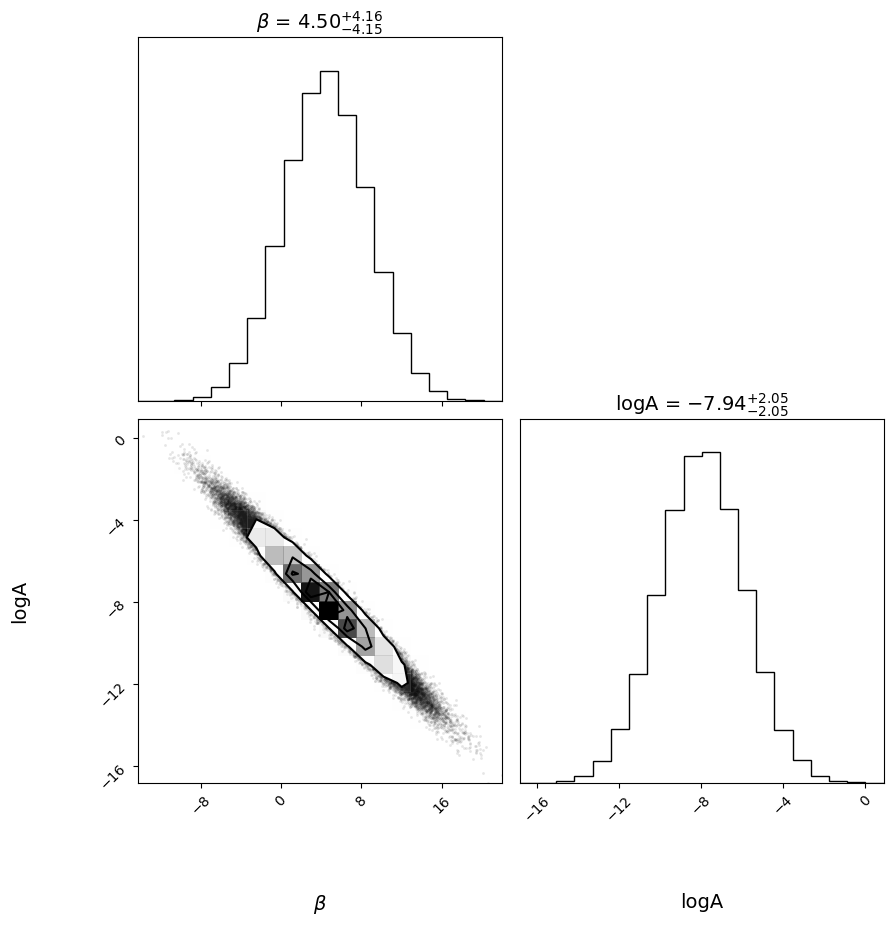

In [31]:
samples_fisher = draw_from_gaussian(res.x, covariance_matrix, ndraws=100000)

plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(samples_fisher[:,::-1], show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

# HMC

In [51]:
from jax import random
from numpyro.infer import MCMC, NUTS, HMC
import numpyro


potential=jax.jit( lambda GRF_args: 0.5*GRF_Loss(GRF_args))

nwalkers=2
numpyro.set_host_device_count(nwalkers)
numpyro.enable_x64(True)
initial_guess=[-7.932,4.476]
nuts_kernel = NUTS(potential_fn= potential)
mcmc = MCMC(nuts_kernel, num_warmup=1, num_samples=100,num_chains=nwalkers)

In [ ]:
rng_key = random.PRNGKey(0)
p0=np.repeat(np.expand_dims(initial_guess, axis=0), nwalkers, axis=0)
mcmc.run(rng_key,init_params=p0,extra_fields=('potential_energy',))

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

<Figure size 1000x1000 with 0 Axes>

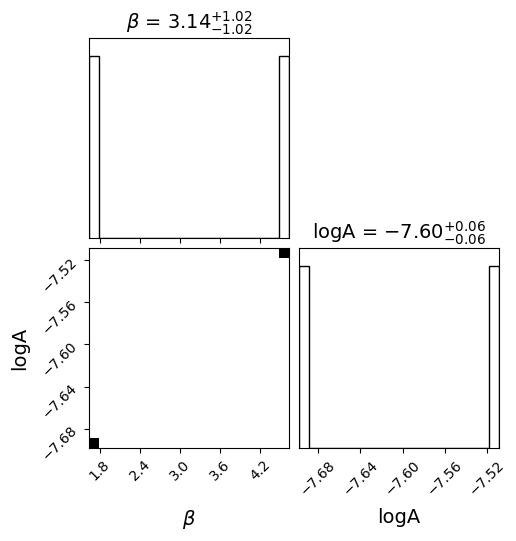

In [50]:
import corner
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='black')
chain = mcmc.get_samples()
fig = corner.corner(np.array(chain)[:,::-1], show_titles=True,  labels=[r'$\beta$','logA'],
                    title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})

It doesn't make any sense at all. So we can probably rely on best fit value, but the real likelihoods are not Gaussian, so Fisher analysis won't help. MCMC should be an option. Actually given the derivatives we could use HMC and I could also heavily paralelize it, but just for sanity check I don't think it is worth it

## MCMC

In [43]:
import emcee
init_stds = [0.3,0.1]
initial_guess=[-7.932,4.476]
bounds=((-10., -7.), (0., 5.))
def in_bounds(args):
    return (args[0]>bounds[0][0]) and (args[0]<bounds[0][1]) and (args[1]>bounds[1][0]) and (args[1]<bounds[1][1])


# here we need to define a non-jitted log-likelihood function
def log_likelihood_nojit(args):
    if in_bounds(args):
        Loss=GRF_parallel_Loss(args)
        return -0.5*Loss
    else:
        return -np.inf

import os

os.environ["OMP_NUM_THREADS"] = str(max_thread_numbers)

nwalkers=max_thread_numbers
ndim=2


filename = './data/Aymerics_data/MCMC_chain.h5'

"""
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

p0=np.zeros((nwalkers,2))
p0[:,0]=np.random.normal(initial_guess[0], init_stds[0],size=nwalkers)
p0[:,1]=np.random.normal(initial_guess[1], init_stds[1],size=nwalkers)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_nojit,backend=backend)
"""

In [ ]:
#state = sampler.run_mcmc(p0, 1000,progress=True)

  0%|          | 1/1000 [03:21<55:56:23, 201.59s/it]

In [ ]:
"""
new_backend = emcee.backends.HDFBackend(filename)
print("Initial size: {0}".format(new_backend.iteration))
new_sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood_nojit, backend=new_backend
)
new_sampler.run_mcmc(None, 1000,progress=True)
print("Final size: {0}".format(new_backend.iteration))
"""

Initial size: 14


 80%|████████  | 805/1000 [2:21:58<1:47:45, 33.16s/it]

In [ ]:
#samples = sampler.get_chain(flat=True)
#log_prob_samples = sampler.get_log_prob(flat=True)
#np.savez('./data/Aymerics_data/MCMC_result',samples=samples,log_prob_samples=log_prob_samples)

In [49]:
chain=new_sampler.get_chain(flat=True)

In [32]:
#arr=np.load('./data/Aymerics_data/MCMC_result.npz')
#chain=arr['samples']
#log_prob=arr['log_prob_samples']

In [69]:
np.power(10,1.6/3)

3.4145488738336014

In [73]:
np.log10(GRF_class.field_variance([-7.4,4.],field='potential'))

-3.0076265289563557

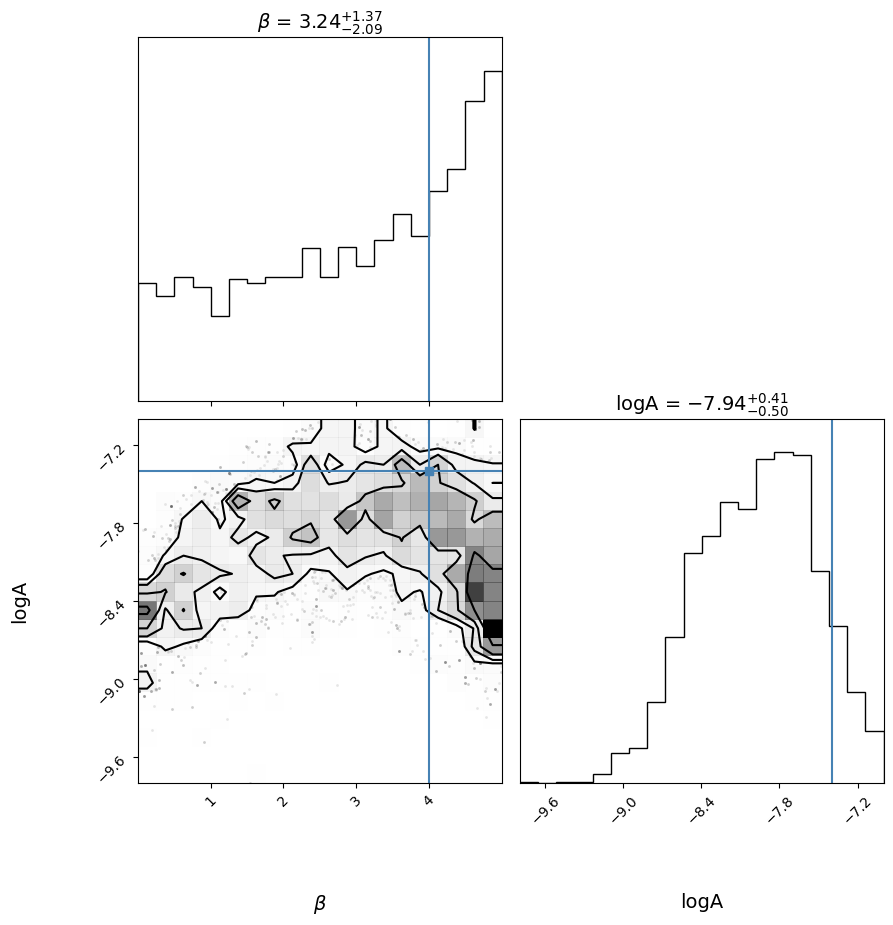

In [75]:
import corner
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(chain[300:,::-1], show_titles=True, labels=[r'$\beta$','logA'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[4.,-7.4])
plt.show()

Well, apparently your GRF is really on the very border of the detectability, so the likelihood for Beta is spreaded over entire considered space of values.
I draw this conclusion because of the shape of the likelihood contour that matches the shape of line SNR=0 (look up grey region in the paper Fig.4 the right row)

## Result GRFs

So these are the fields that I use in LensImage.simulation, specifically in the 'kwargs_lens' as {'pixels': field}

for maximum likelihood value you will have something like this


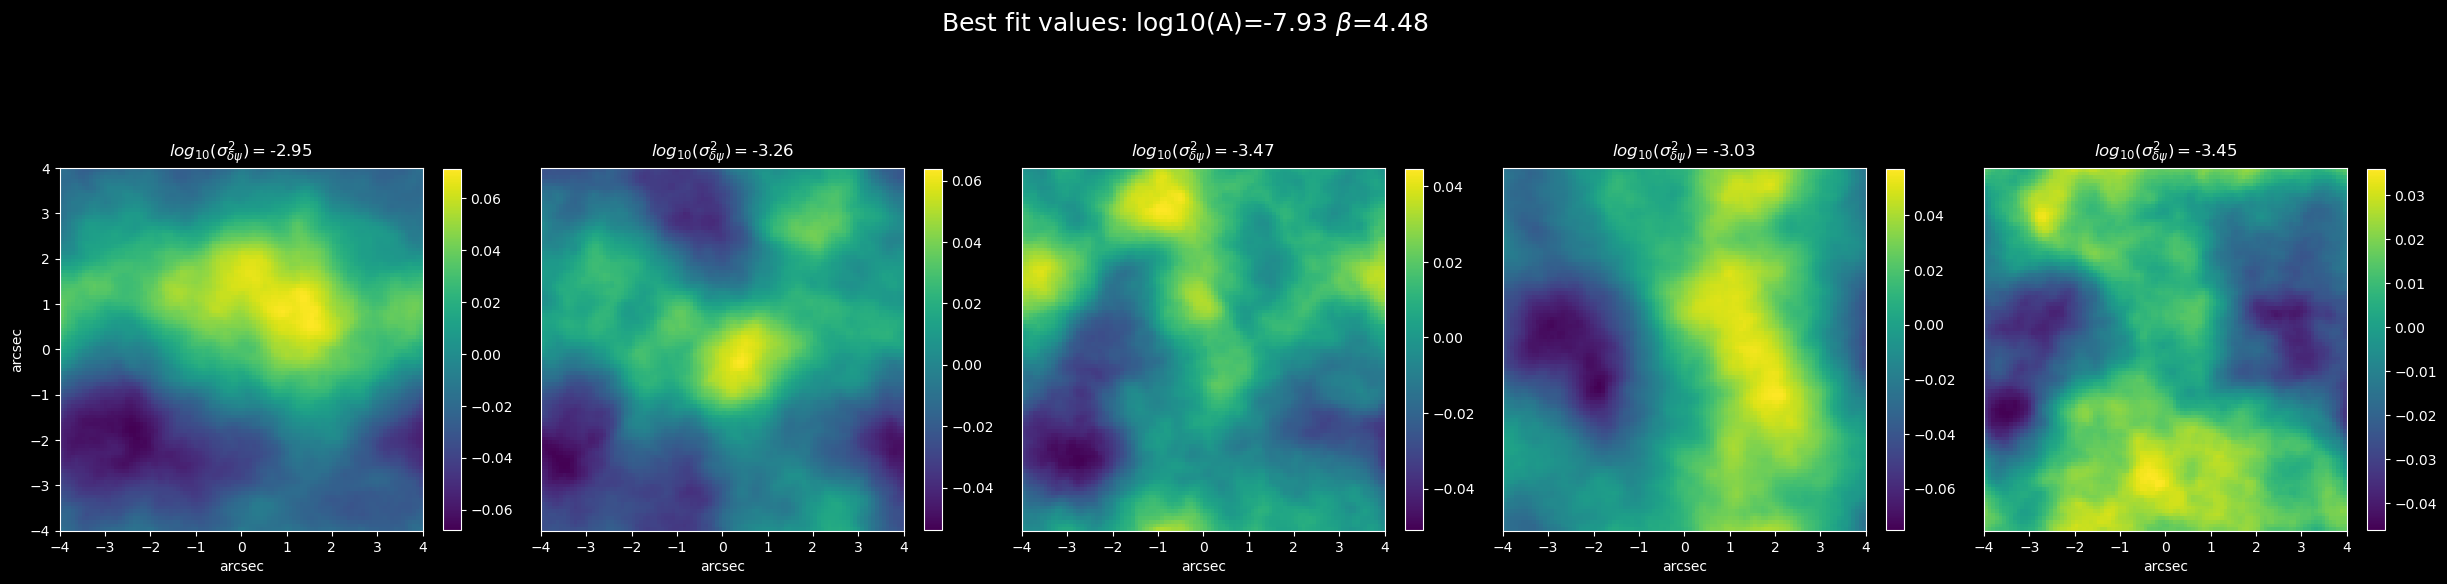

In [53]:
plt.style.use('dark_background')
fig,ax=plt.subplots(1,5,figsize=(30,7),facecolor='black')

for i in range(5):
    field=GRF_class.potential(initial_guess,GRF_class.tensor_unit_Fourier_images[i])
    img=ax[i].imshow(field,extent=extent(data.shape,pixel_scale))

    ax[i].set_title(r'$log_{10}(\sigma^2_{\delta \psi})=$'+'{:.2f}'.format(np.log10(field.var())))

    fig.colorbar(img,ax=ax[i],fraction=0.045)
    ax[i].set_xlabel('arcsec')
    if i==0:
        ax[i].set_ylabel('arcsec')
    else:
        ax[i].set_yticks([])

fig.suptitle('Best fit values: log10(A)={:.2f} '.format(initial_guess[0])+r'$\beta$'+'={:.2f}'.format(initial_guess[1]),fontsize=FS)
plt.show()

In [56]:
print("Mean logVariance from Parseval's theorem is {:.3f}".format(np.log10(GRF_class.field_variance(initial_guess,field='potential'))))

Mean logVariance from Parseval's theorem is -3.151


for MCMC results there are quite weak constraints on Beta, but we can still get what would be the variance in the median logA and its 1sigma

In [57]:
variance_chain=np.array([GRF_class.field_variance(sample,field='potential') for sample in chain])

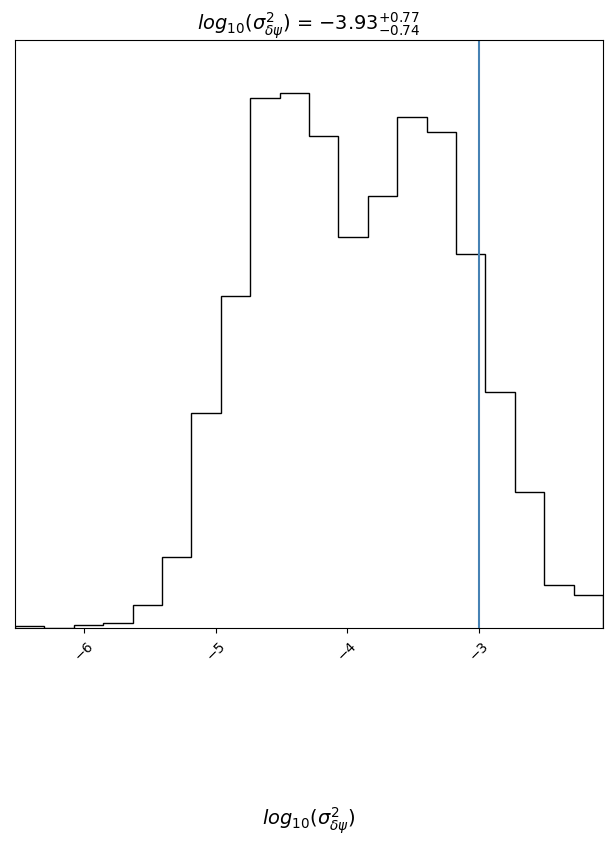

In [76]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.log10(variance_chain[300:]), show_titles=True, labels=[r'$log_{10}(\sigma^2_{\delta \psi})$'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[-3])
plt.show()

In [59]:
deflection_chain=np.array([GRF_class.field_variance(sample,field='alpha_x')+
                           GRF_class.field_variance(sample,field='alpha_y') for sample in chain])

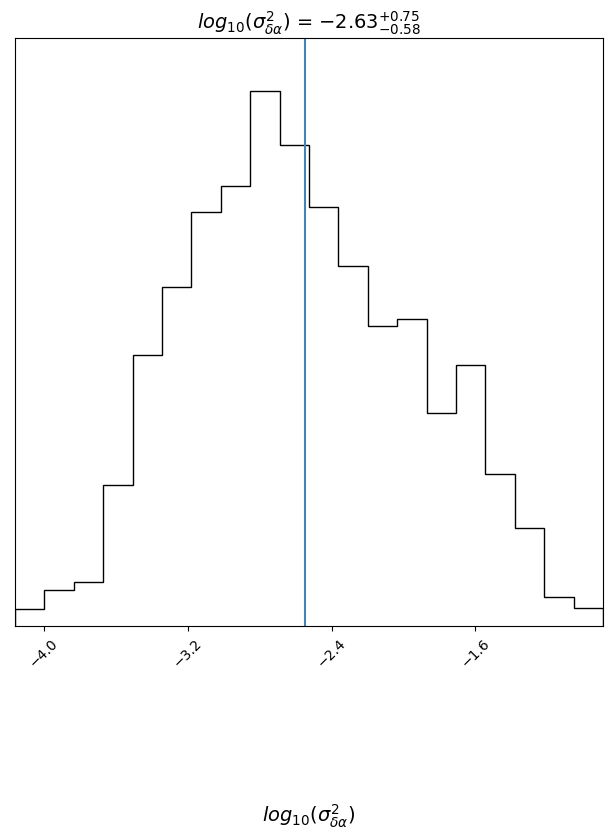

In [80]:
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(np.log10(deflection_chain[300:]), show_titles=True, labels=[r'$log_{10}(\sigma^2_{\delta \alpha})$'],fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[-2.55])
plt.show()

In [87]:
def_Beta_chain=np.zeros_like(chain)
def_Beta_chain[:,0]=np.log10(deflection_chain)
def_Beta_chain[:,1]=chain[:,1]

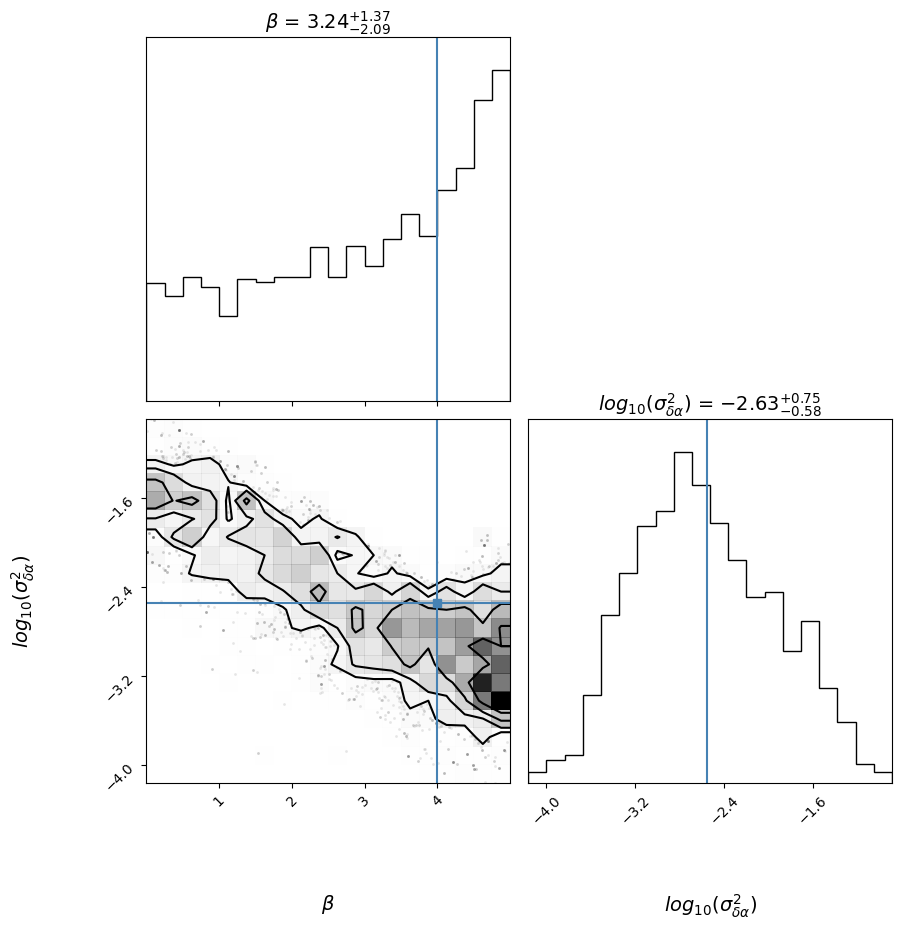

In [88]:
import corner
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(def_Beta_chain[300:,::-1], show_titles=True, labels=[r'$\beta$',r'$log_{10}(\sigma^2_{\delta \alpha})$'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[4.,-2.55])
plt.show()

In [89]:
convergence_chain=np.array([GRF_class.field_variance(sample,field='kappa') for sample in chain])

In [91]:
np.log10(GRF_class.field_variance([-7.4,4.],field='kappa'))

-0.9552890209468298

In [92]:
conv_Beta_chain=np.zeros_like(chain)
conv_Beta_chain[:,0]=np.log10(convergence_chain)
conv_Beta_chain[:,1]=chain[:,1]

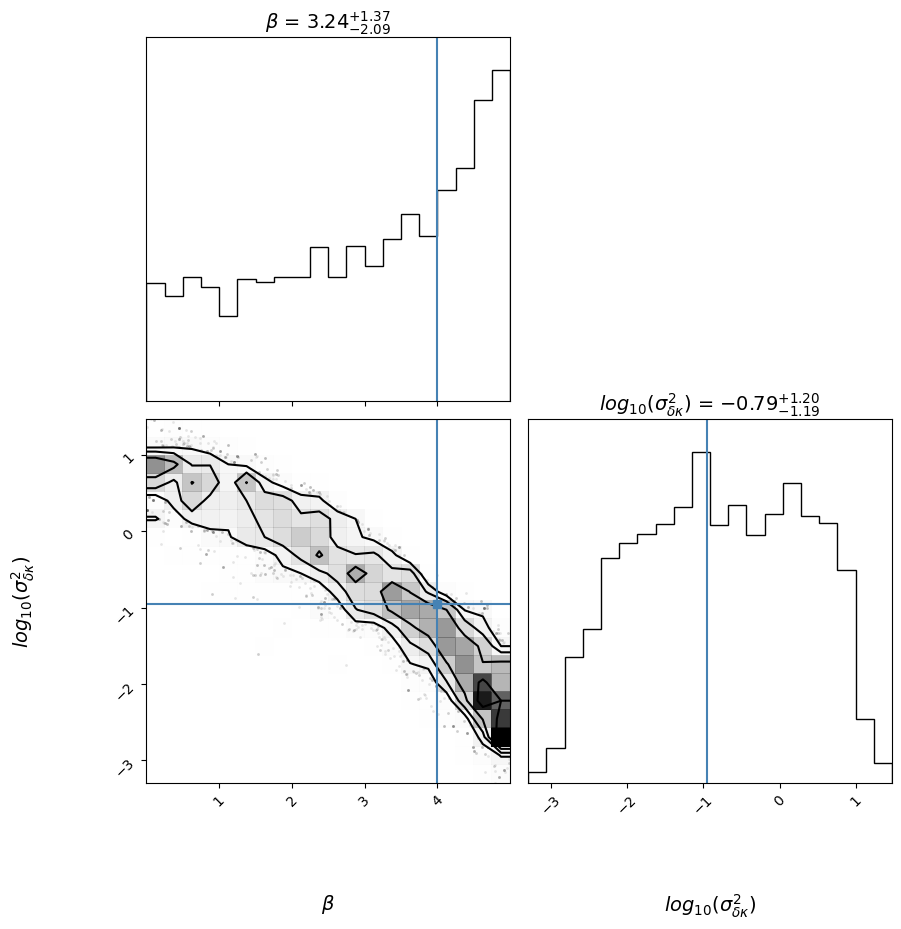

In [93]:
import corner
plt.style.use('default')
fig = plt.figure(figsize=(10, 10),facecolor='white')
fig = corner.corner(conv_Beta_chain[300:,::-1], show_titles=True, labels=[r'$\beta$',r'$log_{10}(\sigma^2_{\delta \kappa})$'],
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14},truths=[4.,-0.955])
plt.show()

If you want to compare the values of log(A) my conventions are as follows:

Power spectrum:
$P(k)=A \cdot k^{-\beta}$,
$log(A)=log_{10}(A)$,
$Fourier\_Image(k)=\sqrt{P(k)/2}(R+i*I)$,
where R and I are standard normal variates. As far as I remember in Giorgos' script
he put 2 into the definition of power spectrum, not to the part with sampling

Parseval's theorem:
$\sigma^2_{\delta \psi}=\sum_{k} P(k)$

Fourier transform is like:
np.fft.ifftn(Fourier_image,norm='backward') * pixel_number**2
where pixel_number=100

basically it should mean that my norm is 'forward'

Changing the norm should change log(A) by 1 or 2.



